In [1]:
import sys, os, time
import numpy as np
import pandas as pd
from collections import Counter
from scipy.spatial.distance import cdist, pdist

from anomatools.models import kNNO, iNNE, SSkNNO, SSDO

import matplotlib.pyplot as plt
%matplotlib inline

%reload_ext autoreload
%autoreload 2

# Generate some time series data

For this tutorial, I will use the TwoPatterns dataset that I downloaded here:

http://www.timeseriesclassification.com/description.php?Dataset=TwoPatterns

After downloading and storing the data, I will first load them from the text files and plot them.

In [2]:
ts_path = '/Users/vincentvercruyssen/projects/maintained_repositories/anomatools/data/time_series/TwoPatterns/'

# load the train data
with open(os.path.join(ts_path, 'TwoPatterns_TRAIN.txt'), 'r') as f:
    lines = f.readlines()
ts_train = []
for line in lines:
    nl = [float(l.strip()) for l in line.split(' ') if not(l == '')]
    ts_train.append(nl)
ts_train = np.array(ts_train)
print('Size of the training data:', ts_train.shape)

# load the test data
with open(os.path.join(ts_path, 'TwoPatterns_TEST.txt'), 'r') as f:
    lines = f.readlines()
ts_test = []
for line in lines:
    nl = [float(l.strip()) for l in line.split(' ') if not(l == '')]
    ts_test.append(nl)
ts_test = np.array(ts_test)
print('Size of the testing data:', ts_test.shape)

# combine the train and test set and extract the labels
ts = np.vstack((ts_train, ts_test))
print('Size of the combined data:', ts.shape)
original_labels = ts[:, 0].flatten().astype(int)
ts = ts[:, 1:]
print('Number of labels per category:', Counter(original_labels))

Size of the training data: (1000, 129)
Size of the testing data: (4000, 129)
Size of the combined data: (5000, 129)
Number of labels per category: Counter({1: 1306, 2: 1248, 3: 1245, 4: 1201})


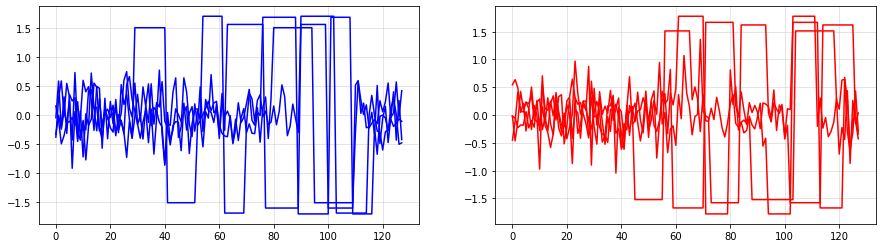

In [3]:
c = 0.05
normal_class = 1
size=500

# construct an anomaly detection dataset (by selecting one class as normal and subsample the other classes to get the anomalies)
ts_normal = ts[original_labels == normal_class, :]
ts_anomaly = ts[original_labels != normal_class, :]
np.random.shuffle(ts_anomaly)
ts_normal = ts_normal[:size, :]
nn = ts_normal.shape[0]
na = int(nn * c)
X = np.vstack((ts_normal, ts_anomaly[:na, :])).astype(np.double)
y = np.ones(X.shape[0])
y[:nn] = -1

# plot the result (10 normals and 10 anomalies)
f, axes = plt.subplots(1, 2, figsize=(15, 4))
Xn = X[y == -1, :]
Xa = X[y == 1, :]
for i in range(4):
    axes[0].plot(np.arange(0, X.shape[1], 1), Xn[i, :], color='blue')
    axes[1].plot(np.arange(0, X.shape[1], 1), Xa[i, :], color='red')
for i in range(2):
    axes[i].grid(alpha=0.4)

# Anomaly detection with different detectors and DTW distance

We need to add our custom (DTW) distance metric to sklearn methods.

First, let's try the different detectors.

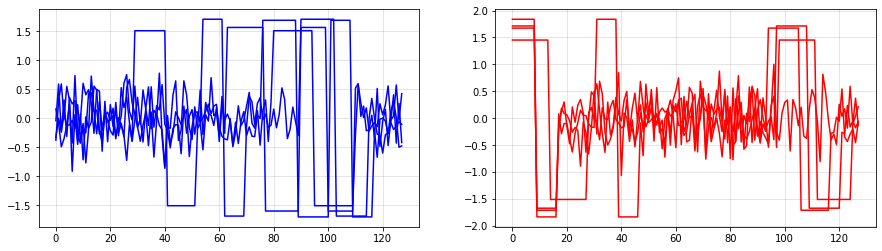

In [4]:
#detector = kNNO(k=10, metric='euclidean', contamination=0.05)
#detector = iNNE(metric='dtw', sample_size=8, contamination=0.05)
detector = SSkNNO(k=10, metric='dtw', contamination=0.05)
#detector = SSDO(metric='dtw',  contamination=0.05)
ytr = detector.fit_predict(X)
test_probs = detector.predict_proba(X, method='unify')[:, 1]  # anomaly probabilities

# plot the result (10 normals and 10 anomalies)
f, axes = plt.subplots(1, 2, figsize=(15, 4))
Xn = X[ytr == -1, :]
Xa = X[ytr == 1, :]
for i in range(4):
    axes[0].plot(np.arange(0, X.shape[1], 1), Xn[i, :], color='blue')
    axes[1].plot(np.arange(0, X.shape[1], 1), Xa[i, :], color='red')
for i in range(2):
    axes[i].grid(alpha=0.4)

### Add some labels

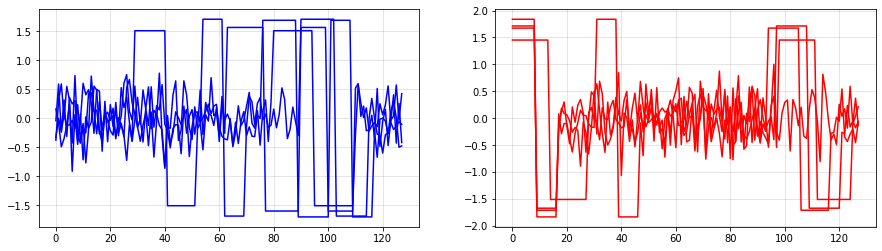

In [7]:
detector = SSkNNO(k=10, metric='dtw', contamination=0.05)
yl = np.zeros(len(y), dtype=int)
yl[:5] = -1
ytr = detector.fit_predict(X, yl)
test_probs = detector.predict_proba(X, method='unify')[:, 1]  # anomaly probabilities

# plot the result (10 normals and 10 anomalies)
f, axes = plt.subplots(1, 2, figsize=(15, 4))
Xn = X[ytr == -1, :]
Xa = X[ytr == 1, :]
for i in range(4):
    axes[0].plot(np.arange(0, X.shape[1], 1), Xn[i, :], color='blue')
    axes[1].plot(np.arange(0, X.shape[1], 1), Xa[i, :], color='red')
for i in range(2):
    axes[i].grid(alpha=0.4)